In [25]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import metrics

from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
columns_drop_metmast = ['Min_Raindetection', 'Avg_Raindetection', 'Avg_Raindetection', 'Anemometer1_Freq', 'Anemometer1_Offset', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 'AirRessureSensorZeroOffset']
columns_drop_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']


In [5]:
df_failures = pd.read_csv(r'../rawdata/wind-farm-1-failures-training.csv', sep=';')


In [51]:
df_signals = pd.read_csv('../rawdata/wind-farm-1-signals-training.csv', sep=';')#, nrows=100000)
#df_signals.columns

In [52]:
columns_gen=['Turbine_ID','Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
      # 'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_TotActPwr',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
      # 'Prod_LatestAvg_ReactPwrGen2',   'Prod_LatestAvg_TotReactPwr',
     'Gen_SlipRing_Temp_Avg','Gen_Bear2_Temp_Avg'
            ]


    
    
columns_gen_select=[ 
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0',
      # 'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_TotActPwr',
       'Prod_LatestAvg_ReactPwrGen0',
     'Gen_SlipRing_Temp_Avg','Gen_Bear2_Temp_Avg'
            ]

In [53]:

df_signals = df_signals.drop(columns=columns_drop_signals)
df_signals = df_signals[columns_gen]
df_signals['Timestamp']=pd.to_datetime(df_signals['Timestamp']).dt.tz_convert(None)
df_signals.head()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Gen_SlipRing_Temp_Avg,Gen_Bear2_Temp_Avg
0,T11,2016-01-01,1339.4,1233.3,1270.9,18.8,42.0,59,61,60,0,41059.0,0,-13521,27,38
1,T06,2016-01-01,1270.0,1232.8,1248.5,6.8,42.0,51,52,53,0,10465.0,0,-12621,26,35
2,T01,2016-01-01,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,-107,4420.0,-99,-5636,25,37
3,T09,2016-01-01,1376.7,1234.3,1272.0,24.7,40.0,58,57,58,0,33173.0,0,-13513,26,33
4,T07,2016-01-01,1317.5,1229.5,1254.9,13.8,41.0,62,62,61,0,18831.0,0,-11991,26,39


In [49]:
df_signals.shape

(434145, 16)

1-dataset tem de estar ordenado primeiro por turbina e depois por timestamp (ascendente)

In [14]:
df_target=pd.read_csv('../rawdata/Miguel/df_target_v2_60_50_40_50_30_20_10.csv', index_col=[0])
df_target['Timestamp']=pd.to_datetime(df_target['Timestamp'])
#df_target.head()

In [37]:
df_failures

,Turbine_ID,Component,Timestamp,Remarks
0,T11,GENERATOR,2016-03-03T19:00:00+00:00,Electric circuit error in generator
1,T06,HYDRAULIC_GROUP,2016-04-04T18:53:00+00:00,Error in pitch regulation
2,T07,GENERATOR_BEARING,2016-04-30T12:40:00+00:00,High temperature in generator bearing (replace...
3,T09,GENERATOR_BEARING,2016-06-07T16:59:00+00:00,High tempemperature generator bearing
4,T07,TRANSFORMER,2016-07-10T03:46:00+00:00,High temperature transformer
5,T06,GENERATOR,2016-07-11T19:48:00+00:00,Generator replaced
6,T01,GEARBOX,2016-07-18T02:10:00+00:00,Gearbox pump damaged
7,T06,GENERATOR,2016-07-24T17:01:00+00:00,Generator temperature sensor failure
8,T09,GENERATOR_BEARING,2016-08-22T18:25:00+00:00,High temperature generator bearing
9,T07,TRANSFORMER,2016-08-23T02:21:00+00:00,High temperature transformer. Transformer refr...


In [85]:
target='Fail_30_GENERATOR'
df_signals_target=pd.merge(df_signals, df_target[['Timestamp','Turbine_ID',target]], how='left', on=['Turbine_ID','Timestamp'])

In [86]:
df_signals_target.Gen_Bear_Temp_Avg.fillna(0,inplace=True)

In [87]:
2500*0.2

500.0

In [88]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [97]:
def bin_classify(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
    
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Clssifier object
        dataframe of model predictions and scores
    
    """
    
    
    X_train = df_train[features]

    X_test = df_test[features] 
    y_train = df_train[target]
    y_test = df_test[target]

    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [131]:
y_pred

NameError: name 'y_pred' is not defined

In [103]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold
        
    """

    
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh

In [114]:
df_failures

,Turbine_ID,Component,Timestamp,Remarks
0,T11,GENERATOR,2016-03-03T19:00:00+00:00,Electric circuit error in generator
1,T06,HYDRAULIC_GROUP,2016-04-04T18:53:00+00:00,Error in pitch regulation
2,T07,GENERATOR_BEARING,2016-04-30T12:40:00+00:00,High temperature in generator bearing (replace...
3,T09,GENERATOR_BEARING,2016-06-07T16:59:00+00:00,High tempemperature generator bearing
4,T07,TRANSFORMER,2016-07-10T03:46:00+00:00,High temperature transformer
5,T06,GENERATOR,2016-07-11T19:48:00+00:00,Generator replaced
6,T01,GEARBOX,2016-07-18T02:10:00+00:00,Gearbox pump damaged
7,T06,GENERATOR,2016-07-24T17:01:00+00:00,Generator temperature sensor failure
8,T09,GENERATOR_BEARING,2016-08-22T18:25:00+00:00,High temperature generator bearing
9,T07,TRANSFORMER,2016-08-23T02:21:00+00:00,High temperature transformer. Transformer refr...


In [111]:
df_train_gen=pd.read_csv('../rawdata/proc_data/df_train_gen.csv')
#df_train_gen.head()

df_test_gen=pd.read_csv('../rawdata/proc_data/df_test_gen_t7.csv')


In [119]:
df_test_gen[df_test_gen['60_days']==1].Timestamp.min()

'2017-06-22 02:50:00+00:00'

In [120]:
df_train_gen['60_days'].value_counts()

0    338816
1     30015
Name: 60_days, dtype: int64

In [113]:
df_test_gen['60_days'].value_counts()

1    8324
0    4712
Name: 60_days, dtype: int64

In [124]:
df_test

,Turbine_ID,Timestamp,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase2_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ReactPwrGen0,Gen_SlipRing_Temp_Avg,...,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Grd_Busbar_Temp_Avg,Hyd_Oil_Temp_Avg,Component,TTF,60_days,30_days,10_days
0,T07,2017-06-01 00:00:00+00:00,1572.8,61.6,59.0,86.0,0.0,131880.0,0.0,37.0,...,38.0,34.0,89.0,40.0,45.0,0.0,82.0,0,0,0
1,T07,2017-06-01 00:10:00+00:00,1471.3,100.5,58.0,84.0,0.0,93277.0,0.0,37.0,...,38.0,34.0,89.0,41.0,45.0,0.0,82.0,0,0,0
2,T07,2017-06-01 00:20:00+00:00,1473.7,106.9,57.0,82.0,0.0,100670.0,0.0,36.0,...,38.0,34.0,95.3,41.0,44.0,0.0,82.0,0,0,0
3,T07,2017-06-01 00:30:00+00:00,1657.8,30.6,56.0,85.0,0.0,255192.0,0.0,37.0,...,40.0,34.0,95.3,42.0,43.0,0.0,82.0,0,0,0
4,T07,2017-06-01 00:40:00+00:00,1655.0,28.6,56.0,90.0,0.0,242673.0,0.0,38.0,...,41.0,35.0,88.3,44.0,43.0,0.0,82.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13031,T07,2017-08-31 23:20:00+00:00,1250.0,8.6,48.0,64.0,0.0,33349.0,0.0,35.0,...,39.0,34.0,102.8,39.0,41.0,0.0,0.0,0,0,0
13032,T07,2017-08-31 23:30:00+00:00,1251.8,8.0,48.0,65.0,0.0,32818.0,0.0,34.0,...,39.0,33.0,95.3,39.0,41.0,0.0,0.0,0,0,0
13033,T07,2017-08-31 23:40:00+00:00,1250.7,7.9,48.0,65.0,0.0,20452.0,0.0,34.0,...,38.0,33.0,91.9,39.0,41.0,0.0,0.0,0,0,0
13034,T07,2017-08-31 23:50:00+00:00,1253.0,12.6,48.0,66.0,0.0,34969.0,0.0,34.0,...,38.0,33.0,87.2,39.0,41.0,0.0,0.0,0,0,0


In [128]:
df_train=df_train_gen
df_test=df_test_gen
features=columns_gen_select
target='30_days'
y_test=df_test_gen[target]

In [135]:
#def bin_classify(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
model = 'Logistic Regression'
clf_LogReg = LogisticRegression(random_state=42, class_weight='balanced')
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_LogReg, pred_LogReg = bin_classify(model, clf_logReg, features,target, df_train,df_test, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_LogReg)




Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [137]:
pred_LogReg[pred_LogReg['y_pred']==0]

pred_LogReg['y_pred']

,y_pred,y_score
0,0,0.024743
1,0,0.024558
2,0,0.022116
3,0,0.029503
4,0,0.033929
...,...,...
13031,0,0.122444
13032,0,0.100699
13033,0,0.111496
13034,0,0.111925


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[8867    0]
 [4169    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      8867
           1       0.00      0.00      0.00      4169

    accuracy                           0.68     13036
   macro avg       0.34      0.50      0.40     13036
weighted avg       0.46      0.68      0.55     13036


Metrics:
           Logistic Regression
Accuracy              0.680193
Precision             0.000000
Recall                0.000000
F1 Score              0.000000
ROC AUC               0.526637

ROC Thresholds:

         Threshold  TP  FP  TN  FN      TPR       FPR  TNR       FNR       Que
0     1.486220e+00   0  25  75   0  0.00000  0.000000  1.0  0.750000  0.000000
1     4.862200e-01   0  24  75   0  0.00024  0.000000  1.0  0.757576  0.000077
2     4.588942e-01   0  24  75   0  0.00072  0.000000  1.0  0.757576  0

/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


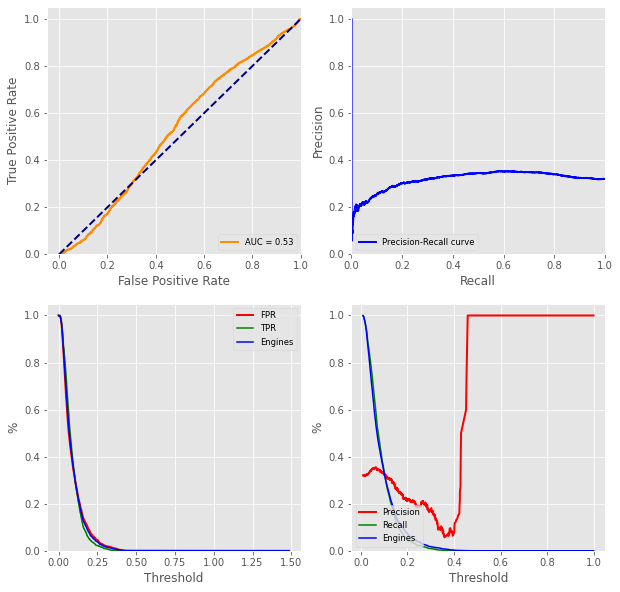

In [130]:
metrics_LogReg, roc_LogReg, prc_LogReg = bin_class_metrics(model, y_test, pred_LogReg.y_pred, pred_LogReg.y_score, print_out=True, plot_out=True)

In [19]:
len_ = int(0.8*df_signals_target.shape[0])

df_train = df_signals_target[:len_]
df_test = df_signals_target[len_:]

In [245]:
var_list=list(df_train.drop(columns=['Turbine_ID', 'Timestamp',target]).columns)

In [246]:
var_list

['Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Prod_LatestAvg_ActPwrGen0',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_TotActPwr',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_ReactPwrGen1',
 'Prod_LatestAvg_TotReactPwr',
 'Gen_SlipRing_Temp_Avg',
 'Gen_Bear2_Temp_Avg']

In [247]:
scaler = StandardScaler()

for i in var_list:
    df_train[i]=scaler.fit_transform(df_train[[i]])
    df_test[i]=scaler.transform(df_test[[i]])

df_train.head()

<ipython-input-247-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[i]=scaler.fit_transform(df_train[[i]])
<ipython-input-247-590c48b68ed8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[i]=scaler.transform(df_test[[i]])
<ipython-input-247-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

<ipython-input-247-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[i]=scaler.fit_transform(df_train[[i]])
<ipython-input-247-590c48b68ed8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[i]=scaler.transform(df_test[[i]])
<ipython-input-247-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_TotReactPwr,Gen_SlipRing_Temp_Avg,Gen_Bear2_Temp_Avg,Fail_30_GENERATOR
0,T11,2016-01-01,0.258079,0.510634,0.357229,-0.440904,-0.231705,-0.147832,-0.069120,-0.091975,0.599216,-0.432245,-0.427453,0.503068,0.139007,0.169069,-0.198930,-0.302107,0
1,T06,2016-01-01,0.150275,0.509819,0.321008,-0.549176,-0.231705,-0.431648,-0.399373,-0.353410,0.599216,-0.708180,-0.702608,0.503068,0.205249,0.237161,-0.317190,-0.516810,0
2,T01,2016-01-01,0.161770,0.498901,0.321816,-0.529326,-0.287618,-0.183309,-0.142509,-0.166671,0.437648,-0.762701,-0.757938,0.359128,0.719361,0.758148,-0.435449,-0.373675,0
3,T09,2016-01-01,0.316021,0.512264,0.359008,-0.387669,-0.343532,-0.183309,-0.215899,-0.166671,0.599216,-0.503371,-0.498378,0.503068,0.139595,0.169674,-0.317190,-0.659946,0
4,T07,2016-01-01,0.224060,0.504441,0.331357,-0.486017,-0.287618,-0.041400,-0.032425,-0.054627,0.599216,-0.632725,-0.627367,0.503068,0.251618,0.284827,-0.317190,-0.230539,0


In [249]:
#Guia para utilização da função final get_X_y:

#1º argumento: dataframe
#2º argumento: número de sequencias a gerar para cada uma das turbinas
#3º argumento: comprimento de cada uma das sequências (nº de timestamps recolhidos para formar uma sequencia)
#4º argumento: especificar a variavel target

numero_de_dias=15

Nvezes_10_minutos=6*24*numero_de_dias

import sequences_generator 
print(Nvezes_10_minutos)


X_train,y_train=sequences_generator.get_X_y(df_train,2000,Nvezes_10_minutos,target)

X_test,y_test=sequences_generator.get_X_y(df_test,500,Nvezes_10_minutos,target)


2160


In [250]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

def init_model():
    
    model = models.Sequential()
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                   #metrics=['accuracy'])
                  metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC()])
    
    return model

In [251]:
neg=int(pd.DataFrame(y_train).value_counts()[0])
pos=int(pd.DataFrame(y_train).value_counts()[1])
total=neg+pos

In [252]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [258]:
X_train.shape

(10000, 2160, 16)

In [256]:
#int(pd.DataFrame(y).value_counts()[1])

In [259]:
class_weight

{0: 0.5329354082285227, 1: 8.090614886731393}

In [260]:

#X_train, y_train = X, y


from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(monitor='val_auc_10', mode='max', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=100, 
            batch_size=32
            ,callbacks=[es]
            ,class_weight=class_weight
                   )

Epoch 1/100
219/219 [==============================] - 132s 601ms/step - loss: 0.6390 - recall_18: 0.9523 - precision_1: 0.1083 - auc_10: 0.8333 - val_loss: 0.8652 - val_recall_18: 0.0783 - val_precision_1: 0.0076 - val_auc_10: 0.3107
Epoch 2/100
219/219 [==============================] - 125s 569ms/step - loss: 0.5114 - recall_18: 0.8966 - precision_1: 0.2396 - auc_10: 0.9116 - val_loss: 0.8663 - val_recall_18: 0.0087 - val_precision_1: 0.0014 - val_auc_10: 0.3840
Epoch 3/100
219/219 [==============================] - 124s 568ms/step - loss: 0.3858 - recall_18: 0.9463 - precision_1: 0.4186 - auc_10: 0.9668 - val_loss: 0.8398 - val_recall_18: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_auc_10: 0.3945
Epoch 4/100
219/219 [==============================] - 122s 556ms/step - loss: 0.3439 - recall_18: 0.9225 - precision_1: 0.5700 - auc_10: 0.9631 - val_loss: 1.1089 - val_recall_18: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_auc_10: 0.3582
Epoch 5/100
219/219 [=======================

Text(0.5, 1.0, '30_Generator')

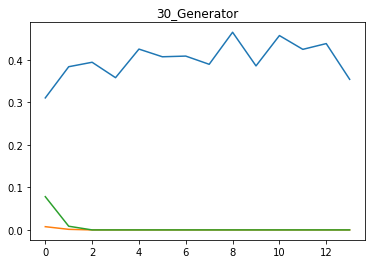

In [271]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_auc_10'])
plt.plot(history.history['val_precision_1'])
plt.plot(history.history['val_recall_18'])

plt.title('30_Generator')

In [272]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'Metric on the test set : {res[1]:.4f}')

Metric on the test set : 0.0000


In [273]:
res

[0.7387657165527344, 0.0, 0.0, 0.4396958351135254]

In [51]:
len(y_train)

4000

In [52]:
len(X_train)

4000

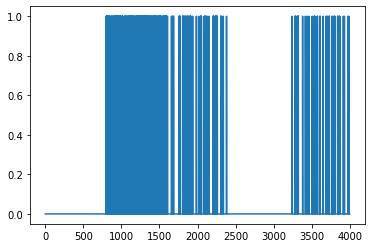

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y_train)